# Test de différents modèles

## Modèle Explicatif (Taux vs Facteurs Environnementaux/Économiques)

### 🔄 Améliorations par rapport à NbCorrected.ipynb :

1. **Imputation sophistiquée** : Utilisation de `IterativeImputer` (via `data_preparation.py`) au lieu de la simple médiane
   - Forward/backward fill par pays pour les séries temporelles
   - IterativeImputer pour les valeurs manquantes restantes (méthode plus robuste)

2. **Encodage automatique** : Les pays (`Country Code`) sont automatiquement encodés en one-hot lors de l'imputation

3. **Pas de SMOTE** : Pour l'instant, nous n'utilisons pas SMOTE (commenté) pour évaluer les performances sans sur-échantillonnage

4. **Architecture simplifiée** : Pas de pipeline imbriqué - les données sont pré-traitées avant la modélisation


In [1]:
# Définir le chemin de base
BASE_PATH = "/mnt/c/Users/ala78/OneDrive - HESSO/BA5/GML/data-gml-health/Refined"

# Définir le dossier
folder_name = "9019"

# Définir le nom du fichier
file_name = "COPD_prevalence_rate"

# Définir le format du fichier (csv, parquet, ...)
file_format = "csv"

In [2]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Ajouter le dossier parent au path pour importer data_preparation
project_root = Path.cwd().parent    
sys.path.append(str(project_root.resolve()))

import COPD.data_preparation as data_preparation

# Chargement des données (adaptez le chemin selon votre fichier)
df = pd.read_csv(f"{BASE_PATH}/{folder_name}/{file_name}.{file_format}")

# Affichage des premières lignes pour vérifier les noms de colonnes
print("Aperçu des données :")
print(df.head())
print("\nNoms des colonnes :")
print(df.columns.tolist())
print("\nTypes de données :")
print(df.dtypes)


Aperçu des données :
      Measure Country Name                                Disease Metric  \
0  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
1  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
2  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
3  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   
4  Prevalence    Indonesia  Chronic obstructive pulmonary disease   Rate   

   Year        Value Country Code  \
0  1990  1193.009546          IDN   
1  1991  1214.971198          IDN   
2  1992  1237.655515          IDN   
3  1993  1260.285392          IDN   
4  1994  1282.440639          IDN   

  Access to clean fuels and technologies for cooking (% of population)  \
0                                                 ..                     
1                                                 ..                     
2                                                 ..                     
3  

In [3]:
df.shape

(4950, 37)

### Étape 1 : Création de la variable cible (Y)

Au lieu de prédire le *changement* (Augmente/Diminue), nous allons prédire le *niveau* du taux lui-même.
Nous divisons le taux `Value` en 3 catégories (quantiles) pour équilibrer les classes :
- 0 : Faible
- 1 : Moyen
- 2 : Élevé

In [4]:
# Utilisation de qcut pour diviser les données en 3 quantiles (tertiles)
# Cela garantit une distribution à peu près égale des classes
try:
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2])
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'])
except ValueError as e:
    print(f"Avertissement lors du qcut : {e}. Il peut y avoir des valeurs dupliquées.")
    # En cas d'échec (par exemple, trop de valeurs identiques), on force
    df['Y_class'] = pd.qcut(df['Value'], q=3, labels=[0, 1, 2], duplicates='drop')
    df['Y_label'] = pd.qcut(df['Value'], q=3, labels=['Faible', 'Moyen', 'Élevé'], duplicates='drop')

print("✓ Variable cible 'Y_class' (0=Faible, 1=Moyen, 2=Élevé) créée.")
print("\nDistribution de la nouvelle variable cible :")
print(df['Y_label'].value_counts())

print("\nExemple de données avec la nouvelle cible :")
print(df[['Country Name', 'Year', 'Value', 'Y_class', 'Y_label']].head())

✓ Variable cible 'Y_class' (0=Faible, 1=Moyen, 2=Élevé) créée.

Distribution de la nouvelle variable cible :
Y_label
Faible    1650
Moyen     1650
Élevé     1650
Name: count, dtype: int64

Exemple de données avec la nouvelle cible :
  Country Name  Year        Value Y_class Y_label
0    Indonesia  1990  1193.009546       1   Moyen
1    Indonesia  1991  1214.971198       1   Moyen
2    Indonesia  1992  1237.655515       1   Moyen
3    Indonesia  1993  1260.285392       1   Moyen
4    Indonesia  1994  1282.440639       1   Moyen


### Étape 1.5 : Préparation et Imputation des Données

Nous allons utiliser les fonctions de `data_preparation.py` pour :
1. Préprocesser les données (remplacer '..' et 'nan' par NaN)
2. Imputer les valeurs manquantes avec la méthode IterativeImputer (plus sophistiquée que la médiane simple)


In [5]:
# Sauvegarder Y_class et Y_label avant l'imputation
y_class_saved = df['Y_class'].copy()
y_label_saved = df['Y_label'].copy()

# Définir uniquement les colonnes à EXCLURE
# (Ce sont les métadonnées et les cibles)
cols_to_exclude = [
    'Measure', 
    'Country Name', 
    'Disease', 
    'Metric', 
    'Y_class', 
    'Y_label'
]

# Sélectionner les colonnes pour l'imputation
df_for_imputation = df.drop(columns=cols_to_exclude).copy()

print("\n⏳ Étape 1/2 : Preprocessing (remplacement de '..' et 'nan' par NaN)...")
df_prepared = data_preparation.preprocessing(df_for_imputation)

print(f"Nombre de NaN après preprocessing :")
print(df_prepared.isnull().sum().sum())

print("\n⏳ Étape 2/2 : Imputation des valeurs manquantes avec IterativeImputer...")
print("⚠️ Cette étape peut prendre quelques minutes...")
df_imputed = data_preparation.impute_nans(df_prepared)

print("\n✓ Imputation terminée !")
print(f"Nombre de NaN après imputation : {df_imputed.isnull().sum().sum()}")

# Récupérer les index originaux et ajouter Y_class et Y_label
df_imputed.index = df.index
df_imputed['Y_class'] = y_class_saved
df_imputed['Y_label'] = y_label_saved

print("\n✓ Données préparées et imputées avec succès !")
print(f"Forme finale : {df_imputed.shape}")



⏳ Étape 1/2 : Preprocessing (remplacement de '..' et 'nan' par NaN)...
Nombre de NaN après preprocessing :
30951

⏳ Étape 2/2 : Imputation des valeurs manquantes avec IterativeImputer...
⚠️ Cette étape peut prendre quelques minutes...
📊 Colonnes détectées pour l'imputation : 31 colonnes
Nombre de NaN après preprocessing :
30951

⏳ Étape 2/2 : Imputation des valeurs manquantes avec IterativeImputer...
⚠️ Cette étape peut prendre quelques minutes...
📊 Colonnes détectées pour l'imputation : 31 colonnes


/home/aladin/gml/GML_RespiratoryDiseases/COPD/data_preparation.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda g: g.ffill().bfill())



✓ Imputation terminée !
Nombre de NaN après imputation : 0

✓ Données préparées et imputées avec succès !
Forme finale : (4950, 197)


In [6]:
df.shape

(4950, 39)

### Étape 1.6 : Feature Engineering - Normalisation des Variables

Pour éviter les biais de corrélation avec la taille des pays, nous créons des features normalisées :
1. **Densité de population** : Remplace la surface (corrélée au pays) par une métrique démographique
2. **Suppression des colonnes totales redondantes** : Élimine les totaux quand une version per capita existe déjà (ex: garder "GDP per capita", supprimer "GDP total")
3. **Ratios per capita** : Transforme des valeurs absolues en valeurs normalisées par habitant
4. **Traitement des variables météo** : Supprime les températures redondantes (skt, d2m corrélées à t2m) et arrondit t2m et sst pour réduire le biais de précision

In [7]:
# FEATURE ENGINEERING : Création de ratios par rapport à la population

print("="*80)
print("LISTE DE TOUTES LES COLONNES DISPONIBLES POUR FEATURE ENGINEERING")
print("="*80)

# Exclure les colonnes de métadonnées et cibles
excluded_for_display = ['Value', 'Y_class', 'Y_label', 'Country Code', 'Year']
available_cols = [col for col in df_imputed.columns 
                  if col not in excluded_for_display and not col.startswith('Country Code_')]

# Afficher toutes les colonnes disponibles
for i, col in enumerate(available_cols, 1):
    print(f"{i:2d}. {col}")

print(f"\n{'='*80}")
print(f"Total : {len(available_cols)} colonnes disponibles")
print("="*80)

LISTE DE TOUTES LES COLONNES DISPONIBLES POUR FEATURE ENGINEERING
 1. Access to clean fuels and technologies for cooking (% of population)
 2. Access to electricity (% of population)
 3. Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)
 4. Compulsory education, duration (years)
 5. GDP (current US$)
 6. GDP per capita (constant 2015 US$)
 7. Gini index
 8. Life expectancy at birth, total (years)
 9. Mortality rate, infant (per 1,000 live births)
10. People using at least basic sanitation services (% of population)
11. Population, total
12. Poverty headcount ratio at national poverty lines (% of population)
13. Renewable electricity output (% of total electricity output)
14. Surface area (sq. km)
15. Unemployment, total (% of total labor force) (national estimate)
16. CO2 emissions
17. Coal consumption
18. Energy use
19. Electricity use
20. Raw materials extracted
21. Oil consumption
22. u10
23. v10
24. d2m
25. t2m
26. sst
27. sp
28. skt
29. blh
30. PM2.5 pollu

In [8]:
# CONFIGURATION : Définir manuellement les colonnes à normaliser par la population
# Ajoutez ou retirez des colonnes selon vos besoins

# Colonnes à transformer en ratio par habitant (per capita)
# Ces colonnes seront divisées par 'Population, total' et la colonne originale sera supprimée
cols_to_normalize_by_population = [
    'CO2 emissions',
    'Total sales of agricultural pesticides (tonnes)',
    'Coal consumption',
    'Energy use',
    'Electricity use',
    'Raw materials extracted',
    'Oil consumption',
    # Ajoutez d'autres colonnes ici selon vos besoins
]

# Colonnes TOTALES à supprimer car elles ont déjà une version per capita
# (ex: 'GDP per capita' existe déjà, donc on supprime 'GDP (current US$)' qui est redondant)
cols_to_drop_total_have_per_capita = [
    'GDP (current US$)',
    'Surface area (sq. km)',
    'Population, total',  # Sera utilisée pour les calculs mais supprimée à la fin
    # Ajoutez d'autres colonnes TOTALES ici selon vos besoins
]

# Colonnes météo redondantes à supprimer (corrélation = 1 avec t2m)
cols_meteo_redundant = ['skt', 'd2m']

# Colonnes météo à arrondir (trop précises, causent du biais)
cols_meteo_to_round = ['t2m', 'sst']

print("📊 FEATURE ENGINEERING - NORMALISATION DES VARIABLES")
print("="*80)

# ========== ÉTAPE 1 : CALCUL DE LA DENSITÉ DE POPULATION ==========
print("\n[1/4] Calcul de la Densité de Population")
print("-" * 80)

if 'Population, total' in df_imputed.columns and 'Surface area (sq. km)' in df_imputed.columns:
    # Calculer la densité (éviter division par zéro)
    df_imputed['Population Density (per sq. km)'] = (
        df_imputed['Population, total'] / df_imputed['Surface area (sq. km)'].replace(0, np.nan)
    )
    
    print(f"✓ Densité calculée : Population Density (per sq. km)")
    print(f"  Stats - Min: {df_imputed['Population Density (per sq. km)'].min():.2f} | "
          f"Max: {df_imputed['Population Density (per sq. km)'].max():.2f} | "
          f"Mean: {df_imputed['Population Density (per sq. km)'].mean():.2f} hab/km²")
else:
    print("⚠️  Colonnes manquantes - Densité non calculée")

# ========== ÉTAPE 2 : CRÉATION DE RATIOS PER CAPITA ==========
print(f"\n[2/4] Création de Ratios Per Capita")
print("-" * 80)
print(f"Colonnes à normaliser : {len(cols_to_normalize_by_population)}\n")

if 'Population, total' not in df_imputed.columns:
    print("❌ ERREUR : La colonne 'Population, total' n'existe pas !")
    print("   Impossible de calculer les ratios.")
else:
    # Créer les ratios
    created_features = []
    removed_features = []
    
    for col in cols_to_normalize_by_population:
        if col in df_imputed.columns:
            # Créer le nom de la nouvelle colonne
            new_col_name = f"{col} (per capita)"
            
            # Calculer le ratio (éviter division par zéro)
            df_imputed[new_col_name] = df_imputed[col] / df_imputed['Population, total'].replace(0, np.nan)
            
            # Supprimer l'ancienne colonne
            df_imputed = df_imputed.drop(columns=[col])
            
            created_features.append(new_col_name)
            removed_features.append(col)
            
            print(f"✓ {col}")
            print(f"  → Créé : {new_col_name}")
            print(f"  → Supprimé : {col}\n")
        else:
            print(f"⚠️  {col} - NON TROUVÉE (ignorée)\n")

# ========== ÉTAPE 3 : SUPPRESSION DES COLONNES TOTALES (ont déjà une version per capita) ==========
print(f"\n[3/4] Suppression des Colonnes Totales (ont déjà une version per capita)")
print("-" * 80)

dropped_totals = []
for col in cols_to_drop_total_have_per_capita:
    if col in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=[col])
        dropped_totals.append(col)
        print(f"✓ Supprimé : {col}")
    else:
        print(f"⚠️  {col} - NON TROUVÉE (ignorée)")

if dropped_totals:
    print(f"\n  Total colonnes totales supprimées : {len(dropped_totals)}")
else:
    print("\n  Aucune colonne à supprimer")

# ========== ÉTAPE 4 : TRAITEMENT DES VARIABLES MÉTÉOROLOGIQUES ==========
print(f"\n[4/4] Traitement des Variables Météorologiques")
print("-" * 80)

# Suppression des températures redondantes (corrélation = 1 avec t2m)
dropped_meteo = []
for col in cols_meteo_redundant:
    if col in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=[col])
        dropped_meteo.append(col)
        print(f"✓ Supprimé (redondant avec t2m) : {col}")
    else:
        print(f"⚠️  {col} - NON TROUVÉE (ignorée)")

# Arrondissement des températures trop précises
rounded_meteo = []
for col in cols_meteo_to_round:
    if col in df_imputed.columns:
        print(f"📊 {col} - Avant arrondissement:")
        print(f"  Exemples de valeurs: {df_imputed[col].head(10).tolist()}")
        print(f"  Nombre de valeurs uniques: {df_imputed[col].nunique()}")
        
        df_imputed[col] = df_imputed[col].round(2)
        rounded_meteo.append(col)
        
        print(f"✓ Arrondi à 1 décimale : {col}")
        print(f"  Exemples après arrondissement: {df_imputed[col].head(10).tolist()}")
        print(f"  Nombre de valeurs uniques après arrondissement: {df_imputed[col].nunique()}\n")
    else:
        print(f"⚠️  {col} - NON TROUVÉE (ignorée)")

if dropped_meteo or rounded_meteo:
    print(f"\n  Colonnes météo supprimées : {len(dropped_meteo)}")
    print(f"  Colonnes météo arrondies : {len(rounded_meteo)}")
else:
    print("\n  Aucune modification météo")

print("\n" + "="*80)
print("📈 RÉSUMÉ DES TRANSFORMATIONS")
print("="*80)
print(f"Features créées  : {len(created_features) + 1}")  # +1 pour la densité
print(f"Features supprimées : {len(removed_features) + len(dropped_totals) + len(dropped_meteo)}")
print(f"  - Colonnes normalisées (remplacées) : {len(removed_features)}")
print(f"  - Colonnes totales (ont déjà version per capita) : {len(dropped_totals)}")
print(f"  - Colonnes météo redondantes : {len(dropped_meteo)}")
print(f"Features arrondies : {len(rounded_meteo)} (températures)")
print(f"Forme du DataFrame : {df_imputed.shape}")
print("="*80)

📊 FEATURE ENGINEERING - NORMALISATION DES VARIABLES

[1/4] Calcul de la Densité de Population
--------------------------------------------------------------------------------
✓ Densité calculée : Population Density (per sq. km)
  Stats - Min: 1.34 | Max: 7856.16 | Mean: 156.41 hab/km²

[2/4] Création de Ratios Per Capita
--------------------------------------------------------------------------------
Colonnes à normaliser : 7

✓ CO2 emissions
  → Créé : CO2 emissions (per capita)
  → Supprimé : CO2 emissions

⚠️  Total sales of agricultural pesticides (tonnes) - NON TROUVÉE (ignorée)

✓ Coal consumption
  → Créé : Coal consumption (per capita)
  → Supprimé : Coal consumption

✓ Energy use
  → Créé : Energy use (per capita)
  → Supprimé : Energy use

✓ Electricity use
  → Créé : Electricity use (per capita)
  → Supprimé : Electricity use

✓ Raw materials extracted
  → Créé : Raw materials extracted (per capita)
  → Supprimé : Raw materials extracted

✓ Oil consumption
  → Créé : Oil con

### Étape 2 : Définition des Features (X)

Nous utilisons toutes les colonnes brutes (environnementales, économiques, etc.) pour expliquer `Y`.

**Note importante** : Après l'imputation avec `data_preparation.impute_nans()`, les colonnes `Country Code` ont été encodées en one-hot encoding (plusieurs colonnes `Country Code_XXX`). C'est pourquoi nous avons maintenant beaucoup plus de features qu'initialement.


In [9]:
# Définition des features (X) et de la cible (y)

# Définir les colonnes qui ne sont PAS des features
# (ce sont vos cibles et la cible d'origine)
cols_to_exclude = ['Value', 'Y_class', 'Y_label']

# features_for_model : toutes les colonnes SAUF les cibles, Year, et Country Code encodés
all_columns = df_imputed.drop(columns=cols_to_exclude).columns.tolist()

# Exclure Year et les colonnes Country Code_XXX pour éviter les biais
features_for_model = [col for col in all_columns 
                      if col != 'Year' and not col.startswith('Country Code_')]

print(f"📊 Filtrage des features :")
print(f"   Total de colonnes disponibles : {len(all_columns)}")
print(f"   Colonnes Country Code exclues : {sum(1 for col in all_columns if col.startswith('Country Code_'))}")
print(f"   Year exclu : {'Year' in all_columns}")
print(f"   Features finales pour modélisation : {len(features_for_model)}")

# Créer le DataFrame pour la modélisation (utiliser df_imputed au lieu de df)
df_model = df_imputed[features_for_model + ['Y_class']].copy()

# Nettoyer les NaN de la cible (s'il y en a eu lors du qcut)
df_model = df_model.dropna(subset=['Y_class'])

print(f"\n✓ Taille du DataFrame pour modélisation : {df_model.shape}")
print(f"✓ Nombre de NaN dans df_model : {df_model.isnull().sum().sum()}")
print(f"\n⚠️ Note : Year et Country Code ont été EXCLUS pour éviter les biais géographiques/temporels")


📊 Filtrage des features :
   Total de colonnes disponibles : 190
   Colonnes Country Code exclues : 163
   Year exclu : True
   Features finales pour modélisation : 26

✓ Taille du DataFrame pour modélisation : (4950, 27)
✓ Nombre de NaN dans df_model : 0

⚠️ Note : Year et Country Code ont été EXCLUS pour éviter les biais géographiques/temporels


In [10]:
df_imputed.shape

(4950, 193)

### Étape 3 : Configuration des Modèles

**Différence avec NbCorrected.ipynb** :
- ✅ Les données sont **déjà imputées** avec `IterativeImputer` (plus sophistiqué que la médiane)
- ✅ Pas besoin de pipeline `ImbPipeline` avec imputer/scaler/SMOTE
- ✅ Pour la Logistic Regression : standardisation des données (nécessaire pour ce modèle)
- ✅ Pour Random Forest et XGBoost : données brutes (ces modèles tree-based n'ont pas besoin de standardisation)
- ⚠️ SMOTE est désactivé pour l'instant (à réactiver si nécessaire)


In [11]:
# Import des bibliothèques pour SMOTE et classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("✓ Bibliothèques importées avec succès pour la classification multi-classe !")
print("="*80)


✓ Bibliothèques importées avec succès pour la classification multi-classe !


In [12]:
# Définition de X et y
X = df_model.drop('Y_class', axis=1)
y = df_model['Y_class'].astype(int)

# Vérifier que toutes les colonnes sont déjà numériques (après l'imputation)
print("Types de données dans X :")
print(X.dtypes.value_counts())

# Vérifier les NaN
print(f"\nNombre total de NaN dans X : {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    print("⚠️ Colonnes avec des NaN :")
    print(X.isnull().sum()[X.isnull().sum() > 0])

# Noms des features finales
feature_names = X.columns.tolist()
print(f"\n✓ {len(feature_names)} features prêtes pour la modélisation")

# ============================================================================
# CONFIGURATION : Nombre de splits (répétitions)
# ============================================================================
N_SPLITS = 100  # Nombre de fois que l'on répète le split 80/20

print(f"\n{'='*80}")
print(f"🔄 VALIDATION PAR RÉPÉTITIONS MULTIPLES")
print(f"{'='*80}")
print(f"   Nombre de répétitions : {N_SPLITS}")
print(f"   Ratio train/test : 80/20")
print(f"   Chaque répétition utilise un random_state différent")
print(f"{'='*80}")

Types de données dans X :
float64    26
Name: count, dtype: int64

Nombre total de NaN dans X : 0

✓ 26 features prêtes pour la modélisation

🔄 VALIDATION PAR RÉPÉTITIONS MULTIPLES
   Nombre de répétitions : 100
   Ratio train/test : 80/20
   Chaque répétition utilise un random_state différent


In [13]:
X.shape

(4950, 26)

In [14]:
# Définition des 3 modèles pour CLASSIFICATION MULTI-CLASSE

print("="*80)
print("CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)")
print("="*80)

# Créer un premier split pour initialiser (sera refait dans la boucle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pour la Logistic Regression, nous allons standardiser
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_with_smote = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000
    ),
    
    'Random Forest': RandomForestClassifier(
        random_state=42, 
        n_estimators=100
    ),
    
    'XGBoost': XGBClassifier(
        objective='multi:softmax',  # Objectif multi-classe
        num_class=3,              # Nombre de classes
        random_state=42, 
        eval_metric='mlogloss'
    )
}

print("\n✓ Modèles créés pour 3 classes :")
for model_name in models_with_smote.keys():
    print(f"  - {model_name}")
    
print(f"\n✓ Premier split créé : {X_train.shape[0]} train / {X_test.shape[0]} test")
print("   (sera refait à chaque itération dans la boucle)")
print("="*80)

CONFIGURATION DES MODÈLES POUR CLASSIFICATION MULTI-CLASSE (3 CLASSES)

✓ Modèles créés pour 3 classes :
  - Logistic Regression
  - Random Forest
  - XGBoost

✓ Premier split créé : 3960 train / 990 test
   (sera refait à chaque itération dans la boucle)


### Étape 4 : Entraînement et Évaluation des Modèles

In [15]:
# Dictionnaire pour stocker les résultats de TOUTES les itérations
all_results = {model_name: {'accuracy': [], 'precision_weighted': [], 
                            'recall_weighted': [], 'f1_weighted': []} 
               for model_name in models_with_smote.keys()}

# Labels des classes pour les rapports
class_labels = ['Faible (0)', 'Moyen (1)', 'Élevé (2)']

print(f"🔄 Entraînement sur {N_SPLITS} splits...", end=" ")

# Boucle sur les différents splits
for split_idx in range(N_SPLITS):
    random_state = 42 + split_idx
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )
    
    # Standardiser pour Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name in models_with_smote.keys():
        # Créer une nouvelle instance du modèle pour chaque split
        if model_name == 'Logistic Regression':
            model = LogisticRegression(random_state=random_state, max_iter=1000)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        elif model_name == 'Random Forest':
            model = RandomForestClassifier(random_state=random_state, n_estimators=100)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        elif model_name == 'XGBoost':
            model = XGBClassifier(objective='multi:softmax', num_class=3, 
                                  random_state=random_state, eval_metric='mlogloss')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Stockage des métriques
        all_results[model_name]['accuracy'].append(accuracy_score(y_test, y_pred))
        all_results[model_name]['precision_weighted'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        all_results[model_name]['recall_weighted'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        all_results[model_name]['f1_weighted'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    
    # Afficher progression tous les 25% ou à la fin
    if (split_idx + 1) % max(1, N_SPLITS // 4) == 0 or split_idx == N_SPLITS - 1:
        print(f"{(split_idx + 1) * 100 // N_SPLITS}%", end=" ")

print("✓")

# Stocker le dernier split pour les matrices de confusion
results_with_smote = {}
for model_name in models_with_smote.keys():
    if model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42 + N_SPLITS - 1, max_iter=1000)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42 + N_SPLITS - 1, n_estimators=100)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_name == 'XGBoost':
        model = XGBClassifier(objective='multi:softmax', num_class=3, 
                              random_state=42 + N_SPLITS - 1, eval_metric='mlogloss')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    results_with_smote[model_name] = {
        'accuracy': all_results[model_name]['accuracy'][-1],
        'precision_weighted': all_results[model_name]['precision_weighted'][-1],
        'recall_weighted': all_results[model_name]['recall_weighted'][-1],
        'f1_weighted': all_results[model_name]['f1_weighted'][-1],
        'y_pred': y_pred
    }
    models_with_smote[model_name] = model

print(f"\n📊 Résumé rapide (moyenne sur {N_SPLITS} splits) :")
print(f"{'Modèle':<22} {'Accuracy':>10} {'F1-Score':>10}")
print("-" * 44)
for model_name in all_results.keys():
    acc = np.mean(all_results[model_name]['accuracy'])
    f1 = np.mean(all_results[model_name]['f1_weighted'])
    print(f"{model_name:<22} {acc:>10.4f} {f1:>10.4f}")

🔄 Entraînement sur 100 splits... 

25% 50% 50% 75% 75% 100% ✓
100% ✓

📊 Résumé rapide (moyenne sur 100 splits) :
Modèle                   Accuracy   F1-Score
--------------------------------------------
Logistic Regression        0.4378     0.4380
Random Forest              0.9411     0.9410
XGBoost                    0.9392     0.9392

📊 Résumé rapide (moyenne sur 100 splits) :
Modèle                   Accuracy   F1-Score
--------------------------------------------
Logistic Regression        0.4378     0.4380
Random Forest              0.9411     0.9410
XGBoost                    0.9392     0.9392


### Étape 4.1 : Statistiques Agrégées sur les N Répétitions

Après avoir effectué plusieurs splits train/test, nous calculons les statistiques descriptives (moyenne, médiane, écart-type, min, max) pour évaluer la stabilité des performances des modèles.

In [16]:
# Calcul et affichage des statistiques agrégées

print("="*100)
print(f"📊 STATISTIQUES AGRÉGÉES SUR {N_SPLITS} RÉPÉTITIONS")
print("="*100)

# Créer un DataFrame avec toutes les statistiques
stats_data = []

for model_name in all_results.keys():
    for metric_name in ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        values = all_results[model_name][metric_name]
        
        stats_data.append({
            'Modèle': model_name,
            'Métrique': metric_name.replace('_', ' ').title(),
            'Moyenne': np.mean(values),
            'Médiane': np.median(values),
            'Écart-type': np.std(values),
            'Min': np.min(values),
            'Max': np.max(values),
            'IC 95% (±)': 1.96 * np.std(values) / np.sqrt(len(values))  # Intervalle de confiance
        })

df_stats = pd.DataFrame(stats_data)

# Affichage par modèle
for model_name in all_results.keys():
    print(f"\n{'─'*100}")
    print(f"🔹 {model_name}")
    print(f"{'─'*100}")
    
    model_stats = df_stats[df_stats['Modèle'] == model_name].copy()
    model_stats = model_stats.drop(columns=['Modèle'])
    
    # Formater les colonnes numériques
    for col in ['Moyenne', 'Médiane', 'Écart-type', 'Min', 'Max', 'IC 95% (±)']:
        model_stats[col] = model_stats[col].apply(lambda x: f"{x:.4f}")
    
    print(model_stats.to_string(index=False))

print(f"\n{'='*100}")

# Tableau récapitulatif simplifié (Moyenne ± Écart-type)
print("\n📋 TABLEAU RÉCAPITULATIF (Moyenne ± Écart-type)")
print("="*100)

summary_data = []
for model_name in all_results.keys():
    row = {'Modèle': model_name}
    for metric_name in ['accuracy', 'f1_weighted']:
        values = all_results[model_name][metric_name]
        mean_val = np.mean(values)
        std_val = np.std(values)
        metric_label = 'Accuracy' if metric_name == 'accuracy' else 'F1-Score'
        row[metric_label] = f"{mean_val:.4f} ± {std_val:.4f}"
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))
print("="*100)

📊 STATISTIQUES AGRÉGÉES SUR 100 RÉPÉTITIONS

────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Logistic Regression
────────────────────────────────────────────────────────────────────────────────────────────────────
          Métrique Moyenne Médiane Écart-type    Min    Max IC 95% (±)
          Accuracy  0.4378  0.4379     0.0142 0.4040 0.4707     0.0028
Precision Weighted  0.4403  0.4410     0.0140 0.4052 0.4710     0.0027
   Recall Weighted  0.4378  0.4379     0.0142 0.4040 0.4707     0.0028
       F1 Weighted  0.4380  0.4381     0.0142 0.4043 0.4703     0.0028

────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Random Forest
────────────────────────────────────────────────────────────────────────────────────────────────────
          Métrique Moyenne Médiane Écart-type    Min    Max IC 95% (±)
          Accuracy  0.9411  0.9414     0.0066 0.9232 0.9566     0.0013
Precision Weigh

/tmp/ipykernel_42688/620651878.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=list(all_results.keys()), patch_artist=True)
/tmp/ipykernel_42688/620651878.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=list(all_results.keys()), patch_artist=True)
/tmp/ipykernel_42688/620651878.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=list(all_results.keys()), patch_artist=True)
/tmp/ipykernel_42688/620651878.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_

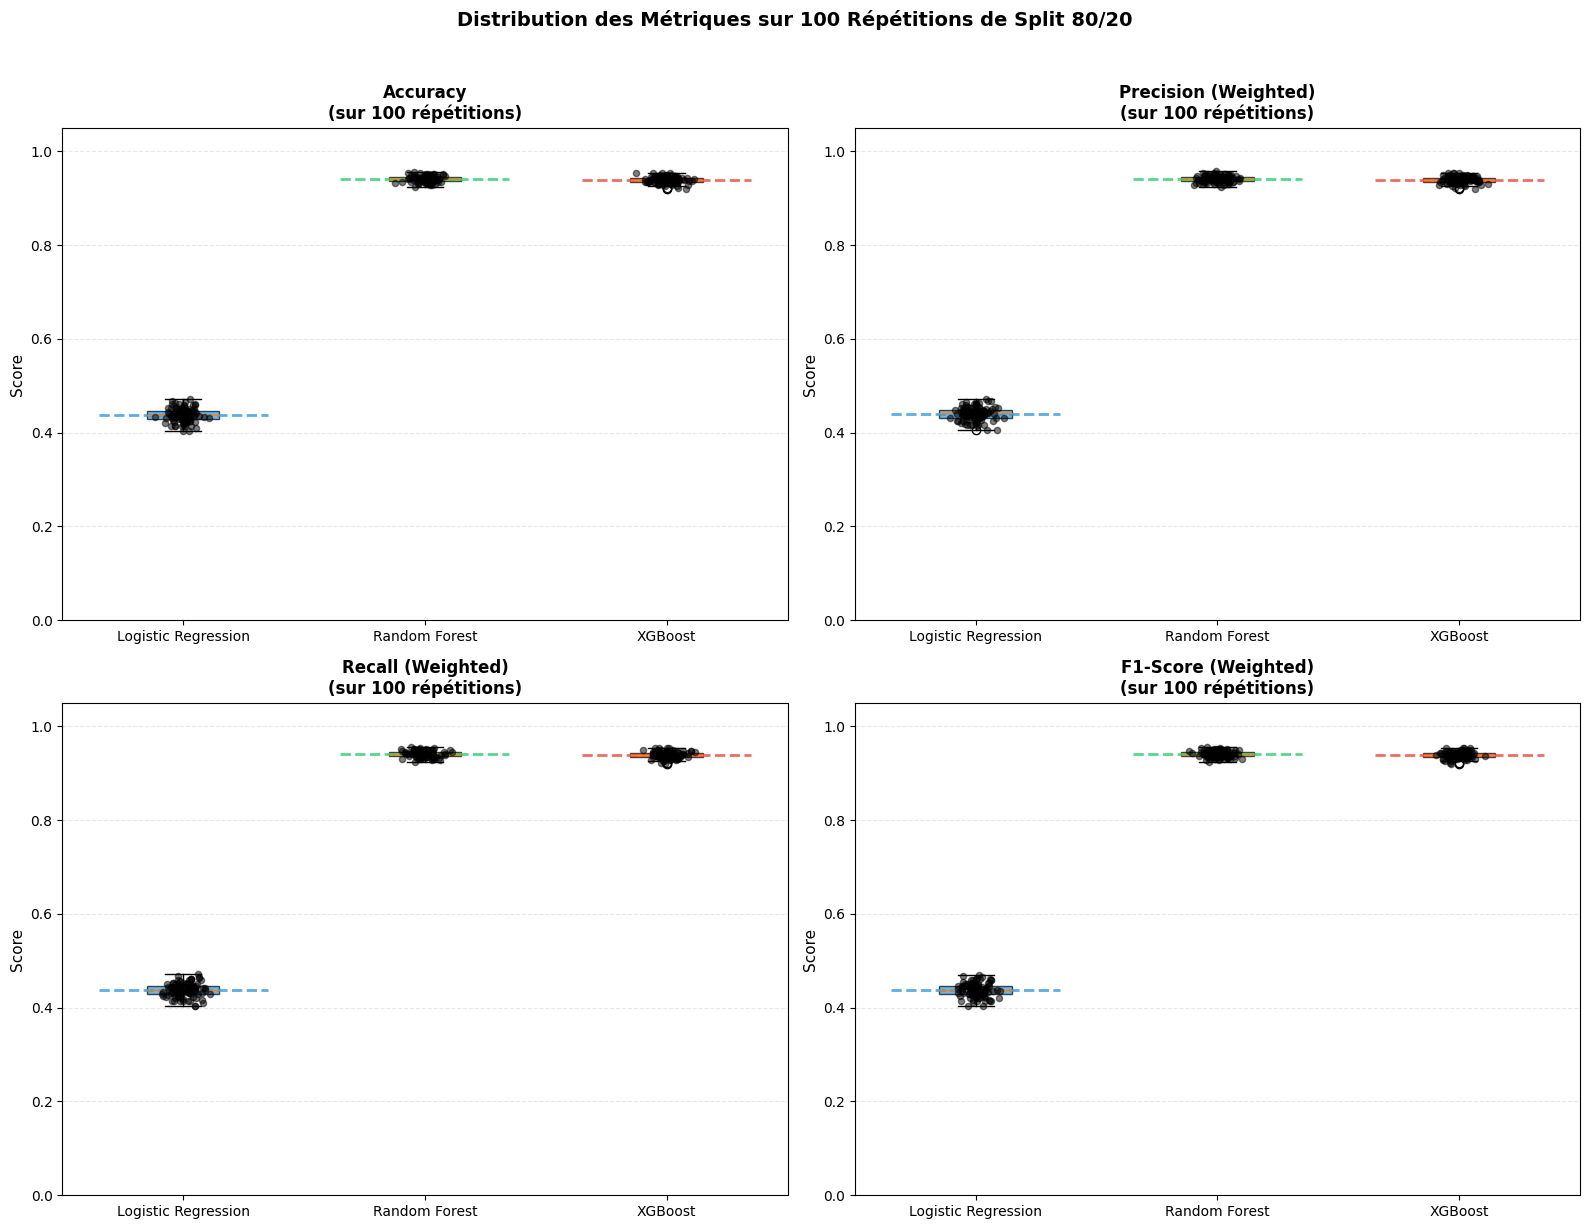

✓ Graphique sauvegardé sous 'metrics_distribution_boxplots.png'


In [17]:
# Visualisation des distributions des métriques avec Boxplots

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_to_plot = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
metric_labels = ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    # Préparer les données pour le boxplot
    data_to_plot = [all_results[model][metric] for model in all_results.keys()]
    
    # Créer le boxplot
    bp = ax.boxplot(data_to_plot, labels=list(all_results.keys()), patch_artist=True)
    
    # Colorier les boxes
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Ajouter les points individuels (scatter)
    for i, (model, values) in enumerate([(m, all_results[m][metric]) for m in all_results.keys()]):
        x = np.random.normal(i + 1, 0.04, size=len(values))
        ax.scatter(x, values, alpha=0.5, color='black', s=20, zorder=3)
    
    ax.set_title(f'{label}\n(sur {N_SPLITS} répétitions)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, 1.05)
    
    # Ajouter les moyennes sur le graphique
    for i, model in enumerate(all_results.keys()):
        mean_val = np.mean(all_results[model][metric])
        ax.axhline(y=mean_val, xmin=(i)/3 + 0.05, xmax=(i+1)/3 - 0.05, 
                   color=colors[i], linestyle='--', linewidth=2, alpha=0.8)

plt.suptitle(f'Distribution des Métriques sur {N_SPLITS} Répétitions de Split 80/20', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("metrics_distribution_boxplots.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphique sauvegardé sous 'metrics_distribution_boxplots.png'")

### Étape 5 : Matrices de Confusion

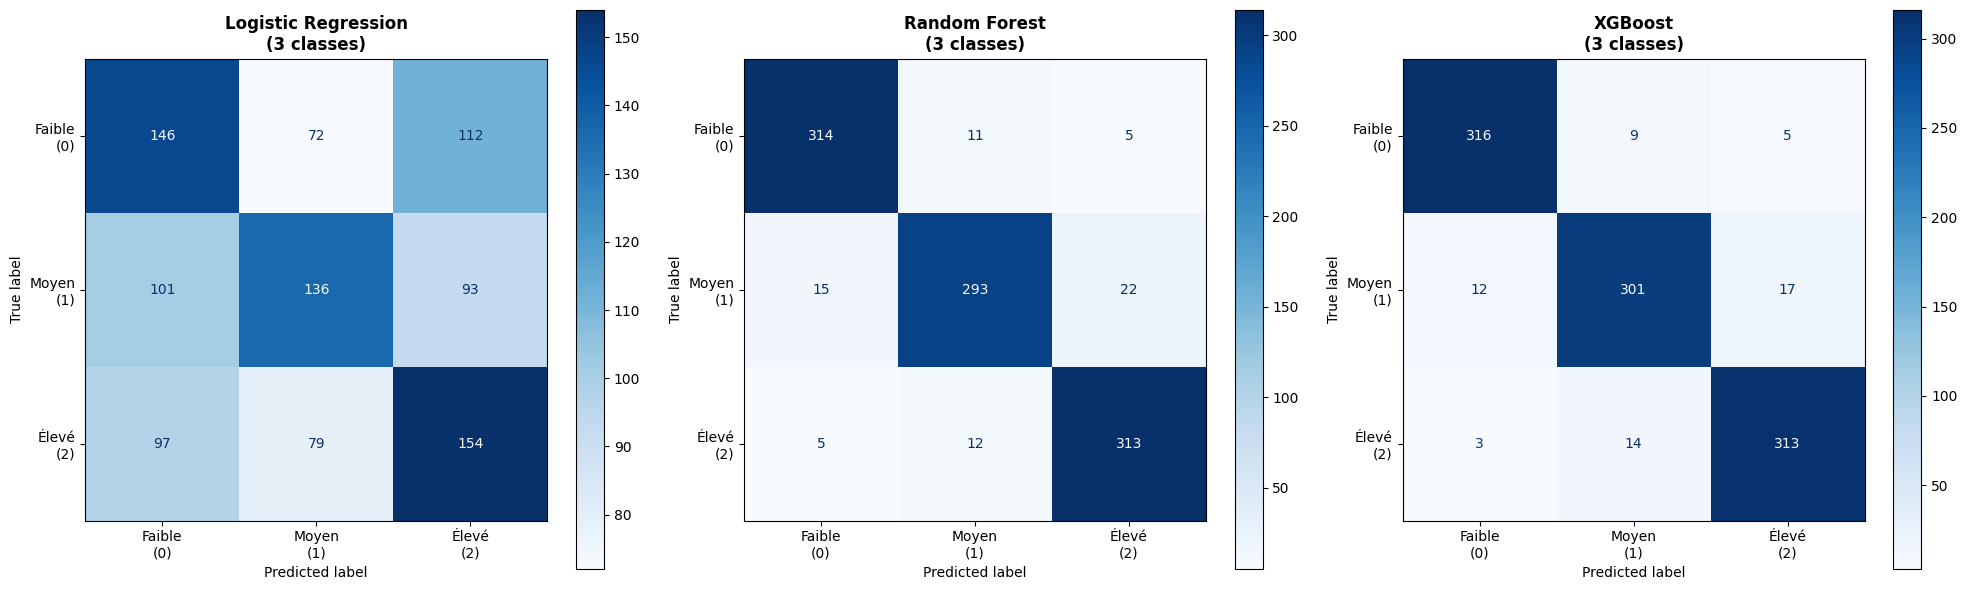

✓ Matrices de confusion affichées pour les 3 classes


In [18]:
# Affichage des matrices de confusion pour les 3 modèles (3 CLASSES)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Labels pour les 3 classes
display_labels = ['Faible\n(0)', 'Moyen\n(1)', 'Élevé\n(2)']

for idx, (model_name, results) in enumerate(results_with_smote.items()):
    y_pred = results['y_pred']
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    
    # Affichage
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=display_labels
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\n(3 classes)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

print("✓ Matrices de confusion affichées pour les 3 classes")
print("="*80)


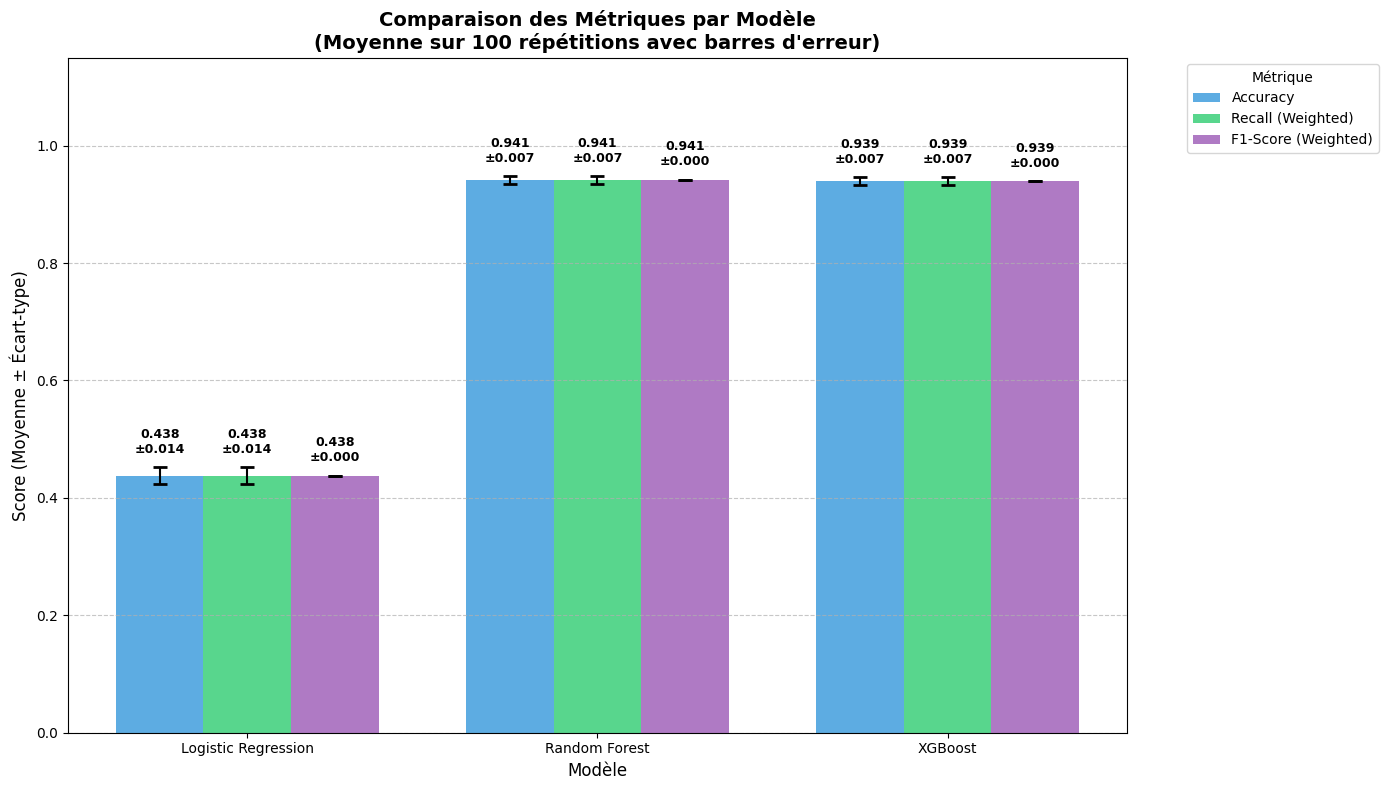

Graphique de comparaison avec écart-type généré et sauvegardé sous 'model_metrics_comparison_with_std.png'


In [19]:
# Graphique comparatif avec barres d'erreur (écart-type)

# Préparer les données avec statistiques
data_list = []
for model_name in all_results.keys():
    data_list.append({
        'Modèle': model_name,
        'Accuracy': np.mean(all_results[model_name]['accuracy']),
        'Accuracy_std': np.std(all_results[model_name]['accuracy']),
        'Recall (Weighted)': np.mean(all_results[model_name]['recall_weighted']),
        'Recall_std': np.std(all_results[model_name]['recall_weighted']),
        'F1-Score (Weighted)': np.mean(all_results[model_name]['f1_weighted']),
        'F1_std': np.std(all_results[model_name]['f1_weighted'])
    })

df_results = pd.DataFrame(data_list)

# Préparer les données pour le graphique
metrics = ['Accuracy', 'Recall (Weighted)', 'F1-Score (Weighted)']
x = np.arange(len(df_results['Modèle']))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))

# Créer les barres avec barres d'erreur
colors = ['#3498db', '#2ecc71', '#9b59b6']
for i, metric in enumerate(metrics):
    std_col = metric.split(' ')[0] + '_std'
    if std_col not in df_results.columns:
        std_col = metric.replace(' (Weighted)', '') + '_std'
    
    means = df_results[metric]
    stds = df_results.get(std_col, [0]*len(means))
    
    bars = ax.bar(x + i*width, means, width, label=metric, color=colors[i], alpha=0.8)
    ax.errorbar(x + i*width, means, yerr=stds, fmt='none', color='black', capsize=5, capthick=2)
    
    # Ajouter les valeurs sur les barres
    for j, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.annotate(f'{mean:.3f}\n±{std:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height + std + 0.02),
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Score (Moyenne ± Écart-type)', fontsize=12)
ax.set_xlabel('Modèle', fontsize=12)
ax.set_title(f'Comparaison des Métriques par Modèle\n(Moyenne sur {N_SPLITS} répétitions avec barres d\'erreur)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(df_results['Modèle'])
ax.legend(title='Métrique', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("model_metrics_comparison_with_std.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Graphique de comparaison avec écart-type généré et sauvegardé sous 'model_metrics_comparison_with_std.png'")

## Étape 6 : Analyse de l'Importance des Features

Maintenant, nous pouvons voir quels facteurs (économiques, environnementaux, etc.) ont le plus d'influence sur la prédiction du taux de BPCO.

In [20]:
# Extraction de l'importance des features pour chaque modèle

# Dictionnaire pour stocker les importances
feature_importances = {}

# Pour chaque modèle, extraire l'importance des features
for model_name, model in models_with_smote.items():
    # Récupérer directement le modèle (plus de pipeline)
    if model_name == 'Logistic Regression':
        # Pour la régression logistique multi-classe, on prend la moyenne des coeffs absolus
        importances = np.abs(model.coef_).mean(axis=0)
        
    elif model_name == 'Random Forest':
        importances = model.feature_importances_
        
    elif model_name == 'XGBoost':
        importances = model.feature_importances_
    
    # S'assurer que les dimensions correspondent
    if len(importances) != len(feature_names):
        # Utiliser seulement les features qui existent
        min_len = min(len(importances), len(feature_names))
        importances = importances[:min_len]
    
    # Stocker les importances
    feature_importances[model_name] = importances

print("✓ Analyse de l'importance des features calculée")


✓ Analyse de l'importance des features calculée


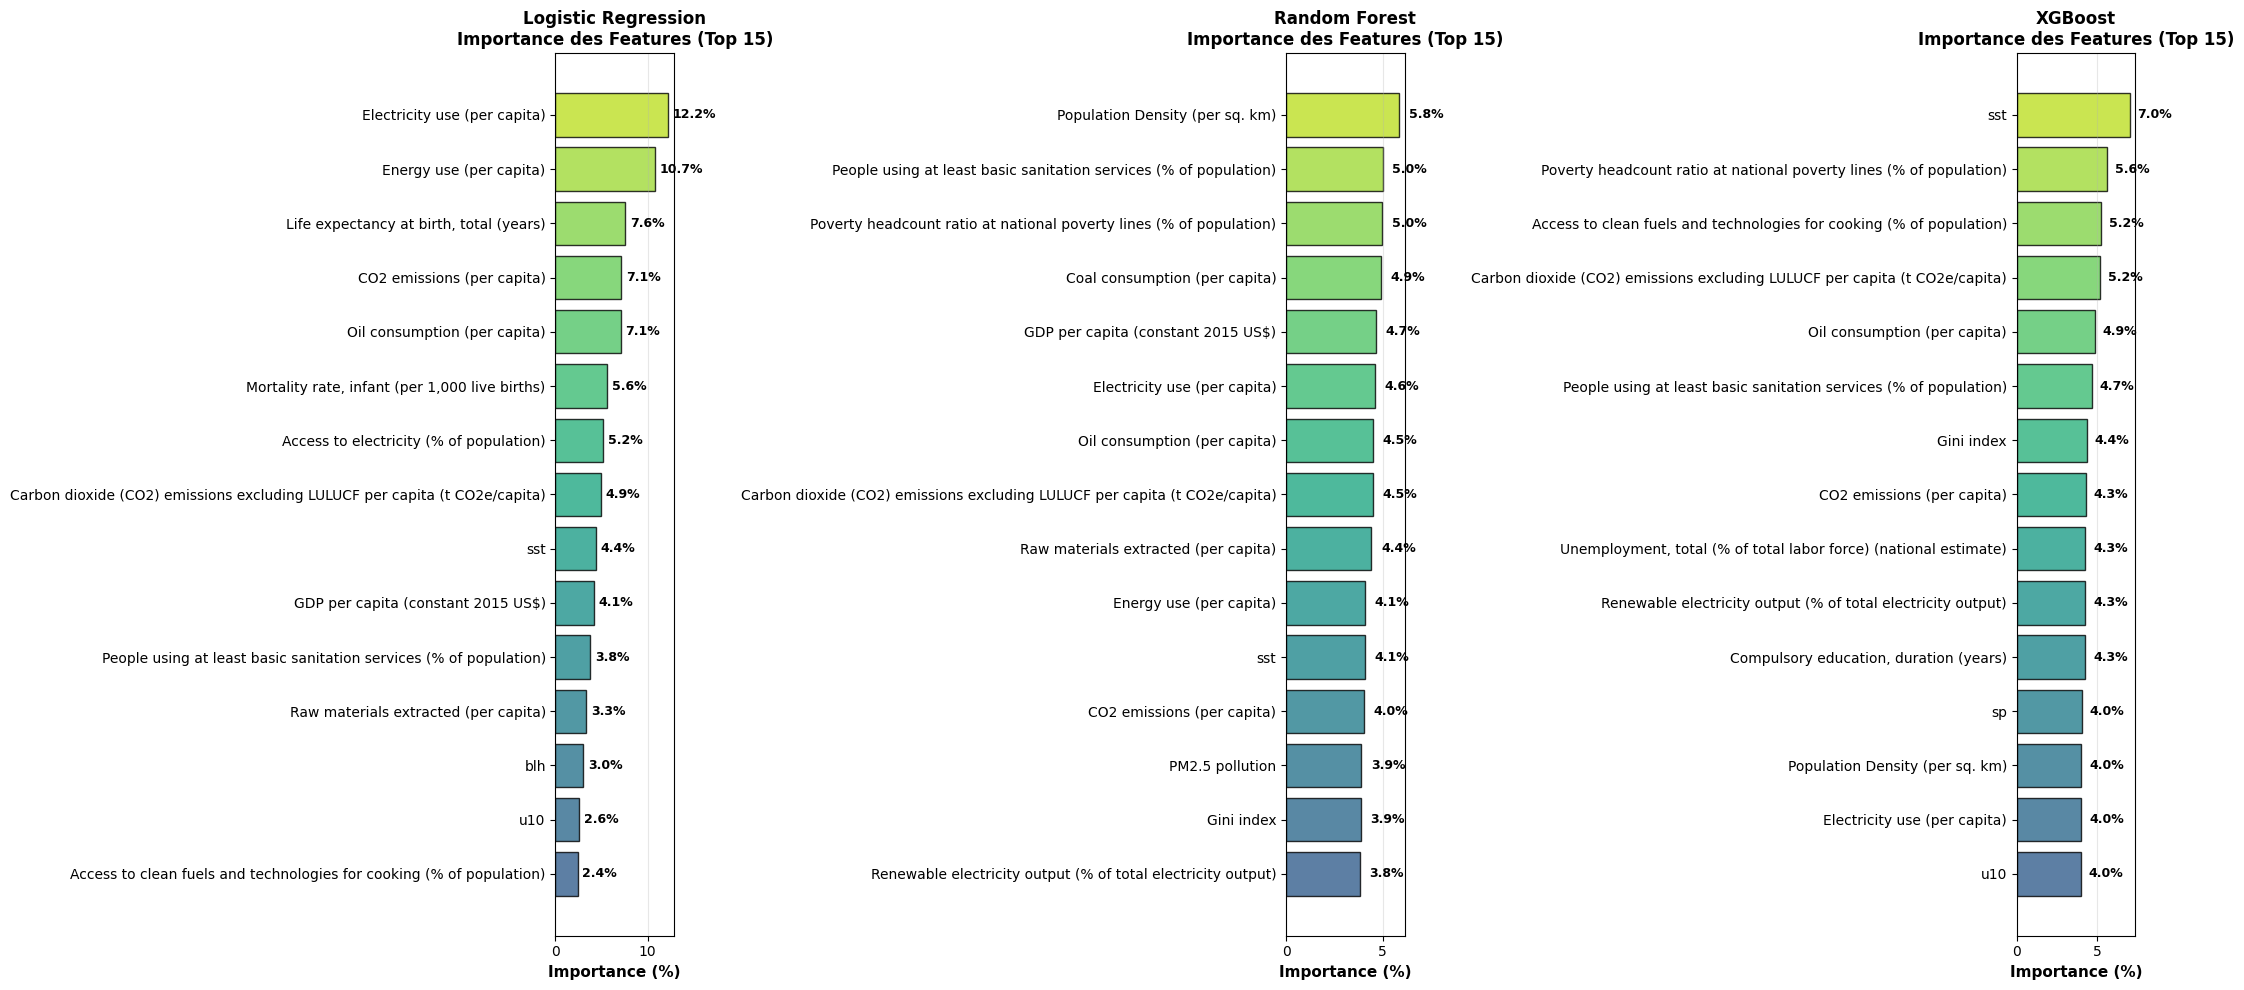

In [21]:
# Visualisation de l'importance des features (Top 15) pour chaque modèle

fig, axes = plt.subplots(1, 3, figsize=(22, 10)) 

for idx, (model_name, importances) in enumerate(feature_importances.items()):
    # Déterminer les noms de features à utiliser
    if len(importances) != len(feature_names):
        min_len = min(len(importances), len(feature_names))
        current_feature_names = feature_names[:min_len]
    else:
        current_feature_names = feature_names
    
    # Créer DataFrame et trier
    importance_df = pd.DataFrame({
        'Feature': current_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15) # Top 15
    
    # Inverser pour affichage horizontal
    importance_df = importance_df.sort_values('Importance', ascending=True)
    
    # Normaliser les importances en pourcentages
    total_importance = importances.sum() # Somme totale de TOUTES les features
    importance_pct = (importance_df['Importance'] / total_importance) * 100
    
    # Couleurs
    colors_palette = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
    
    # Créer le graphique horizontal
    bars = axes[idx].barh(importance_df['Feature'], importance_pct, 
                          color=colors_palette, alpha=0.8, edgecolor='black')
    
    axes[idx].set_xlabel('Importance (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{model_name}\nImportance des Features (Top 15)', 
                        fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar, pct in zip(bars, importance_pct):
        width = bar.get_width()
        axes[idx].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                      f'{pct:.1f}%', 
                      ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


In [22]:
# Comparaison de l'importance des features entre modèles

# Déterminer le nombre de features à utiliser (prendre le minimum)
min_features = min(len(importances) for importances in feature_importances.values())
current_feature_names = feature_names[:min_features]

# Créer un DataFrame pour comparer les importances
comparison_data = {'Feature': current_feature_names}

for model_name, importances in feature_importances.items():
    # Normaliser en pourcentages (utiliser seulement les min_features premières)
    importances_subset = importances[:min_features]
    total = importances_subset.sum()
    pct = (importances_subset / total) * 100
    comparison_data[model_name] = pct

comparison_df = pd.DataFrame(comparison_data)

# Calculer la moyenne et l'écart-type
comparison_df['Moyenne'] = comparison_df[list(feature_importances.keys())].mean(axis=1)
comparison_df['Écart-type'] = comparison_df[list(feature_importances.keys())].std(axis=1)

# Trier par moyenne décroissante
comparison_df = comparison_df.sort_values('Moyenne', ascending=False)

print("📊 TABLEAU COMPARATIF - Top 15 Features\n")
print(comparison_df.head(15).to_string(index=False))


📊 TABLEAU COMPARATIF - Top 15 Features

                                                                   Feature  Logistic Regression  Random Forest  XGBoost  Moyenne  Écart-type
                                              Electricity use (per capita)            12.243392       4.621695 4.027781 6.964289    4.581471
                                                   Energy use (per capita)            10.749459       4.090845 2.460857 5.767054    4.391183
                                              Oil consumption (per capita)             7.071988       4.518795 4.860511 5.483764    1.386013
                                                                       sst             4.420636       4.085464 7.027365 5.177822    1.610495
                                                CO2 emissions (per capita)             7.137898       4.047437 4.296022 5.160452    1.717023
Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)             4.885803       4.502394 5.2

In [23]:
# Export du DataFrame imputé pour éviter de refaire l'imputation à chaque fois
# L'imputation avec IterativeImputer prend beaucoup de temps

import os

# Créer un dossier pour les données prétraitées si nécessaire
output_dir = "preprocessed_data"
os.makedirs(output_dir, exist_ok=True)

# Définir les chemins de sortie
csv_path = os.path.join(output_dir, f"df_imputed_{folder_name}_{file_name}.csv")
parquet_path = os.path.join(output_dir, f"df_imputed_{folder_name}_{file_name}.parquet")

# Export en CSV
print(f"💾 Export en CSV : {csv_path}")
df_imputed.to_csv(csv_path, index=False)
print(f"✓ Exporté avec succès ({os.path.getsize(csv_path) / 1024:.2f} KB)")

# Export en Parquet (format plus compact et rapide)
print(f"\n💾 Export en Parquet : {parquet_path}")
df_imputed.to_parquet(parquet_path, index=False, engine='pyarrow')
print(f"✓ Exporté avec succès ({os.path.getsize(parquet_path) / 1024:.2f} KB)")

print(f"\n{'='*80}")
print("📌 UTILISATION :")
print("="*80)
print("Pour charger les données prétraitées la prochaine fois :")
print()
print("# Option 1 : CSV")
print(f"df_imputed = pd.read_csv('{csv_path}')")
print()
print("# Option 2 : Parquet (plus rapide et compact)")
print(f"df_imputed = pd.read_parquet('{parquet_path}')")
print()
print("# N'oubliez pas de recharger Y_class et Y_label depuis df original :")
print("df_imputed['Y_class'] = y_class_saved")
print("df_imputed['Y_label'] = y_label_saved")
print("="*80)

💾 Export en CSV : preprocessed_data/df_imputed_9019_COPD_prevalence_rate.csv
✓ Exporté avec succès (5092.39 KB)

💾 Export en Parquet : preprocessed_data/df_imputed_9019_COPD_prevalence_rate.parquet
✓ Exporté avec succès (1037.34 KB)

📌 UTILISATION :
Pour charger les données prétraitées la prochaine fois :

# Option 1 : CSV
df_imputed = pd.read_csv('preprocessed_data/df_imputed_9019_COPD_prevalence_rate.csv')

# Option 2 : Parquet (plus rapide et compact)
df_imputed = pd.read_parquet('preprocessed_data/df_imputed_9019_COPD_prevalence_rate.parquet')

# N'oubliez pas de recharger Y_class et Y_label depuis df original :
df_imputed['Y_class'] = y_class_saved
df_imputed['Y_label'] = y_label_saved
✓ Exporté avec succès (5092.39 KB)

💾 Export en Parquet : preprocessed_data/df_imputed_9019_COPD_prevalence_rate.parquet
✓ Exporté avec succès (1037.34 KB)

📌 UTILISATION :
Pour charger les données prétraitées la prochaine fois :

# Option 1 : CSV
df_imputed = pd.read_csv('preprocessed_data/df_imput